In [1]:
from scipy.stats import levy_stable
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Parameters of a target value
min_limit = -2000  # lower range limit of the target value
max_limit = 100  # upper range limit of the target value
precision = 1  # number of decimal places in the target value

# Calculate number of bins along x-axis of distribution
b_num = int((max_limit - min_limit) / 10**(-precision))

# Stop criteria parameters
growth_rate_threshold = 1e-3  # grouth rate, target level of changing distribution after extension the target vector with new portion of samples
growth_rate_length = 5  # number of trials in a row when grouth_rate_limit was reached, to eliminate single or isolated grouth_rate_limit reachings

In [3]:
def get_10days_returns(alpha: float = 1.7, beta: float = 0.0, gamma: float = 1.0, delta: float = 1.0, n_p: int = 751):
    """Calculate a target samples vector with 0.01 quantile of 10-days returns 
    obtained on the base of 1-day returns timeseries
    
    Parameters
    ----------
    alpha : float
        Stability parameter of stable distribution (default is 1.7)
    beta : float
        Skewness parameter of stable distribution (default is 0.0)
    gamma : float
        Scale parameter of stable distribution (default is 1.0)
    delta : float
        Location parameter of stable distribution (default is 1.0)
    n_p : int
        Length of initial prices timeseries (default is 751)

    Returns
    -------
    np.ndarray
        target samples vector
    
    """
    
    # Randomly generate timeserise of prices
    p = levy_stable.rvs(alpha, beta, gamma, delta, size=n_p)
    
    # Calculate 1-day returns timeseries
    r1 = np.diff(p) / p[:-1]
    
    # Calculate overlapping 10-days returns timeseries
    r10 = []
    for i in range(len(r1)-10+1):
        r10.append(np.prod((1 + r1)[i:i+10]) - 1)
    r10 = np.array(r10)
    
    # Get 0.01 quantile values of 10-days returns
    r10_001 = r10[r10 <=  np.quantile(r10, 0.01)]
    return(r10_001)

Number of trials:  173
Number of trials:  342


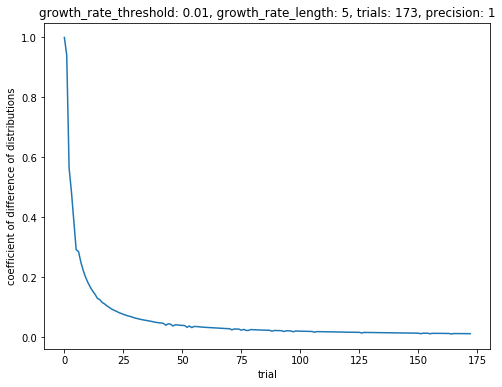

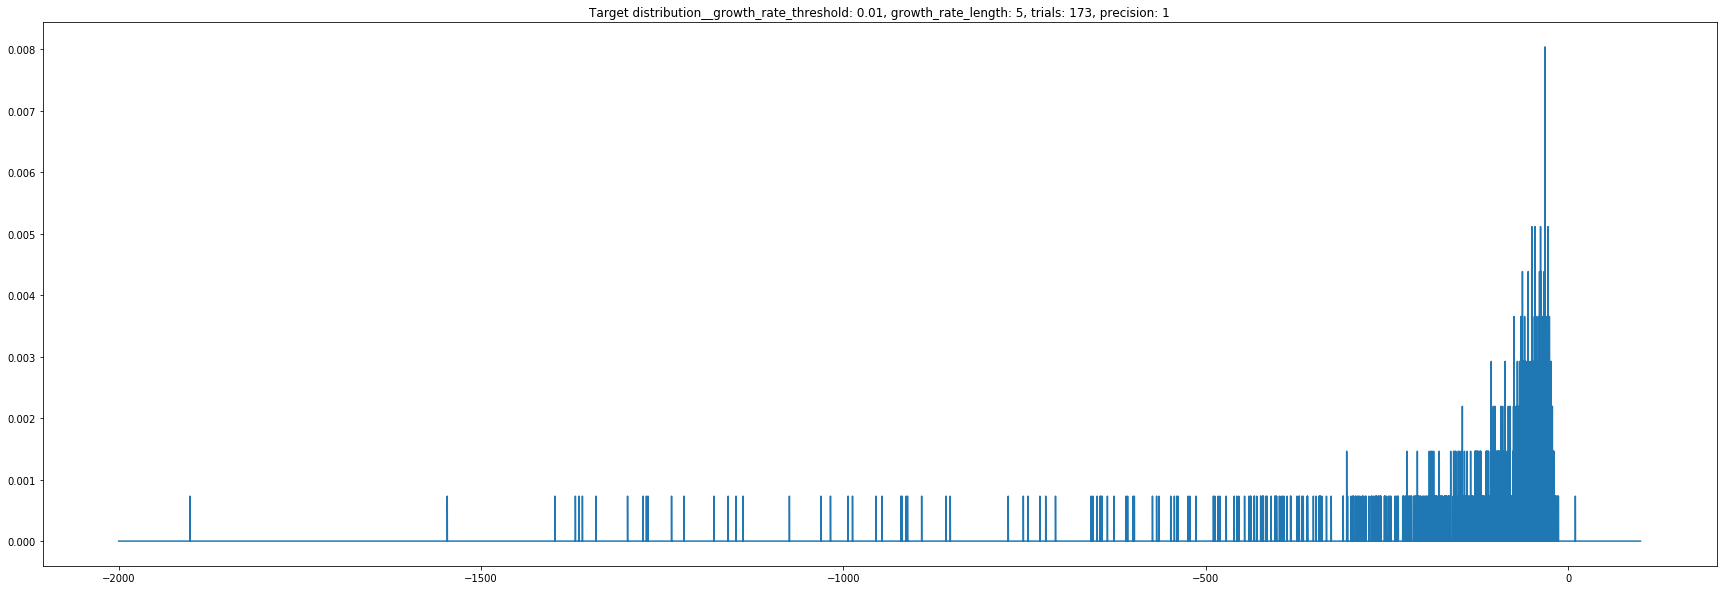

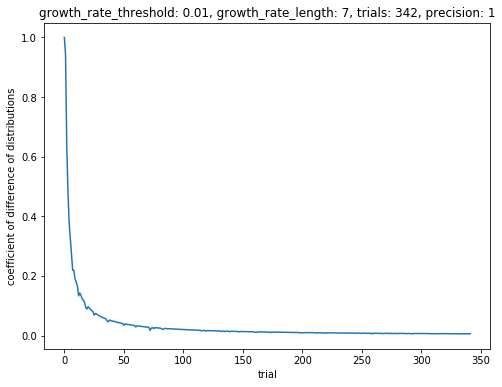

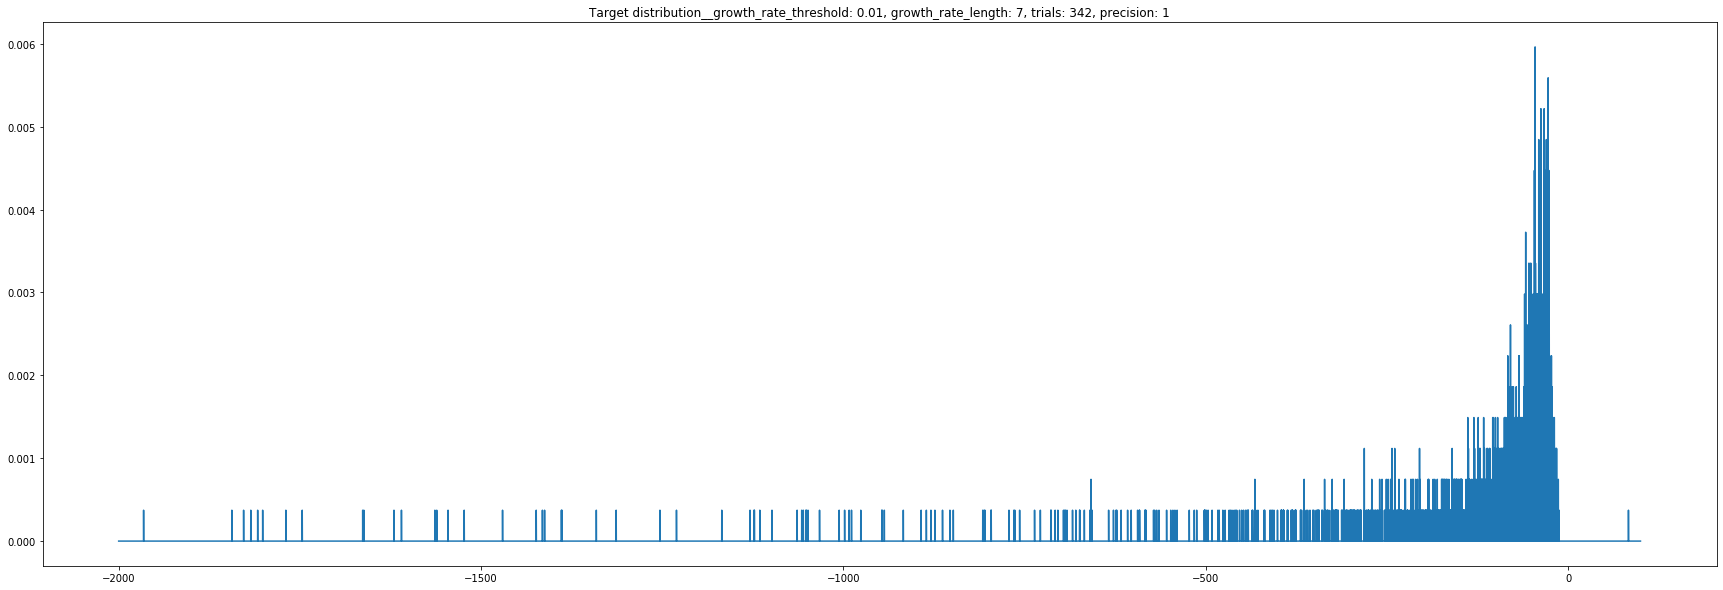

In [6]:
for precision in [1]:
    # Calculate number of bins along x-axis of distribution
    b_num = int((max_limit - min_limit) / 10**(-precision))
    
    for growth_rate_threshold in [1e-2]:
        for growth_rate_length in [5, 7]:
            
            n = 1000000  # maximum numbers of trials

            # Make operations at the first trial
            difference_coeffs = [1]  # list for pair-wise distributions' difference coefficient estimates
            target_samples = np.empty(shape=(1,))  # target samples vector array
            target_samples = np.append(target_samples, np.round(get_10days_returns(), precision))

            # Calculate and normilize distribution
            probability_distribution_previous, _ = np.histogram(target_samples,bins=b_num,range=(min_limit,max_limit))
            probability_distribution_previous = probability_distribution_previous / probability_distribution_previous.sum()


            for i in range(1, n):
                target_samples = np.append(target_samples, np.round(get_10days_returns(), precision))
                probability_distribution_current, bin_ranges = np.histogram(target_samples,bins=b_num,range=(min_limit,max_limit))
                probability_distribution_current = probability_distribution_current / probability_distribution_current.sum()  # нормировка распределения

                # Estimate difference of distributions at previous and current trials
                difference_coeffs.append(abs(probability_distribution_previous - probability_distribution_current).sum())

                probability_distribution_previous = probability_distribution_current.copy()

                # Check stop criteria
                if len(difference_coeffs) > growth_rate_length:
                    growth_rate_array = np.zeros(shape=(growth_rate_length,))
                    for j in range(growth_rate_length):
                        growth_rate = (difference_coeffs[i-growth_rate_length+j] - difference_coeffs[i-growth_rate_length+j+1]) / difference_coeffs[i-growth_rate_length+j]
                        growth_rate_array[j] = growth_rate  # can be modified further by appending a new element to the end of once created and filled array and deleting first element at each iteration
                        #2 values will be changed at one iteration, not growth_rate_length elements
                    if np.where((growth_rate_array < growth_rate_threshold) & (growth_rate_array > 0))[0].shape[0] == growth_rate_length:
                        print('Number of trials: ', i+1)
                        break


            # Plot difference_coeffs sequence during Monte-Carlo procedure to ensure that probability distribution is being adjusted
            plt.figure(figsize=(8,6))
            plt.xlabel('trial')
            plt.ylabel('coefficient of difference of distributions')
            plt.title(f'growth_rate_threshold: {growth_rate_threshold}, growth_rate_length: {growth_rate_length}, trials: {i+1}, precision: {precision}')
            _ = plt.plot(difference_coeffs)
            plt.savefig(f'difference_coefficient__grt={growth_rate_threshold}_grl={growth_rate_length}_trials={i+1}_precision={precision}.jpg')

            # Plot target distribution
            plt.figure(figsize=(30,10))
            plt.title(f'Target distribution__growth_rate_threshold: {growth_rate_threshold}, growth_rate_length: {growth_rate_length}, trials: {i+1}, precision: {precision}')
            _ = plt.plot(bin_ranges[:-1], probability_distribution_current)
            plt.savefig(f'target_distribution__grt={growth_rate_threshold}_grl={growth_rate_length}_trials={i+1}_precision={precision}.jpg')

In [25]:
np.save(f'target_distribution__grt={growth_rate_threshold}_grl={growth_rate_length}_number of trials={i+1}.npy', np.vstack((bin_ranges[:-1],probability_distribution_current)), allow_pickle=True)

# If you didn't wait for the stop of simulation by criteria, plot figures at the maximum available trial

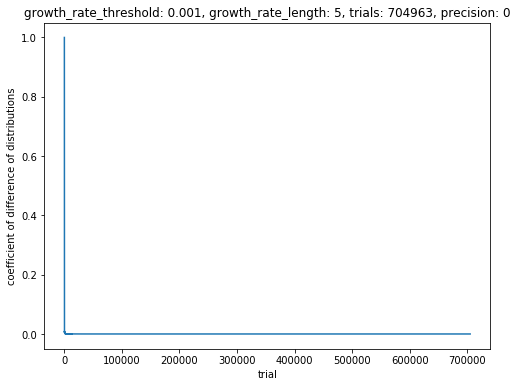

In [40]:
# Plot difference_coeffs sequence during Monte-Carlo procedure to ensure that probability distribution is being adjusted
plt.figure(figsize=(8,6))
plt.xlabel('trial')
plt.ylabel('coefficient of difference of distributions')
plt.title(f'growth_rate_threshold: {growth_rate_threshold}, growth_rate_length: {growth_rate_length}, trials: {i+1}, precision: {precision}')
_ = plt.plot(difference_coeffs)
plt.savefig(f'difference_coefficient__grt={growth_rate_threshold}_grl={growth_rate_length}_trials={i+1}_precision={precision}.jpg')

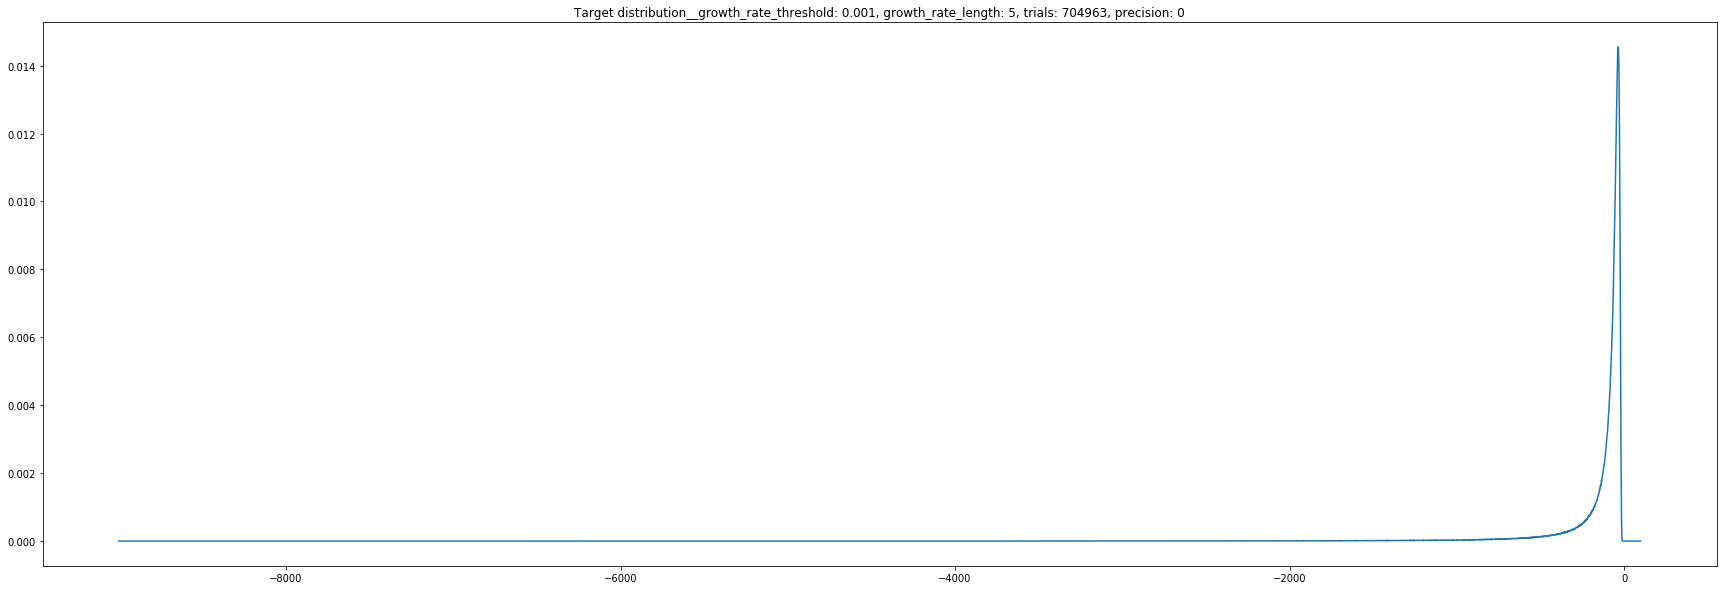

In [41]:
# Plot target distribution
plt.figure(figsize=(30,10))
plt.title(f'Target distribution__growth_rate_threshold: {growth_rate_threshold}, growth_rate_length: {growth_rate_length}, trials: {i+1}, precision: {precision}')
_ = plt.plot(bin_ranges[:-1], probability_distribution_current)
plt.savefig(f'target_distribution__grt={growth_rate_threshold}_grl={growth_rate_length}_trials={i+1}_precision={precision}.jpg')